In [61]:
# import zipfile
# with zipfile.ZipFile('promoter_all.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [1]:
!unzip promoter_all.zip

Streaming output truncated to the last 5000 lines.
  inflating: combined/promoter_2179.png  
  inflating: combined/promoter_2205.png  
  inflating: combined/promoter_2207.png  
  inflating: combined/promoter_2215.png  
  inflating: combined/promoter_2219.png  
  inflating: combined/promoter_2230.png  
  inflating: combined/promoter_2232.png  
  inflating: combined/promoter_2252.png  
  inflating: combined/promoter_2256.png  
  inflating: combined/promoter_2263.png  
  inflating: combined/promoter_2278.png  
  inflating: combined/promoter_2288.png  
  inflating: combined/promoter_2301.png  
  inflating: combined/promoter_2313.png  
  inflating: combined/promoter_2322.png  
  inflating: combined/promoter_2328.png  
  inflating: combined/promoter_2333.png  
  inflating: combined/promoter_2344.png  
  inflating: combined/promoter_2358.png  
  inflating: combined/promoter_2361.png  
  inflating: combined/promoter_2368.png  
  inflating: combined/promoter_2394.png  
  inflating: combined/pro

In [4]:
cd ../

/content


In [2]:
cd combined/

/content/combined


In [3]:
!ls -1 | wc -l

10202


In [5]:
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from natsort import natsorted

In [6]:
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelBinarizer

In [8]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Concatenate, Flatten, MaxPooling2D, Convolution2D, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU, Bidirectional
from keras.regularizers import l2,l1
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model

Using TensorFlow backend.


In [9]:
from keras.metrics import AUC, Precision, Recall

In [10]:
label = pd.read_csv('label.csv')['label'].values

In [11]:
#label = np.asarray(label).reshape(-1,1)

In [12]:
### use label encoder
lb = LabelBinarizer()
label = lb.fit_transform(label)

In [13]:
label
# done label

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [14]:
data = natsorted(os.listdir('combined/'))

In [15]:
len(data)
data[:4]

['non_promoter_0.png',
 'non_promoter_1.png',
 'non_promoter_2.png',
 'non_promoter_3.png']

In [16]:
#len(off),len(target)
samples = len(data)

# height x width is the standard
dims = (4,300)
#ideal 4x28
# 54x390
shape = (samples, dims[0], dims[1], 1)     

dataset = np.ndarray(shape=shape,dtype=np.float32)

In [17]:
i=0
for item in data:
    img1 = load_img('combined/'+ item, target_size=dims, color_mode='grayscale',interpolation='nearest')  # this is a PIL image
    # Convert to Numpy Array
    x1 = img_to_array(img1)
    dataset[i] = x1
    i += 1
    if i % 1000 == 0:
        print("%d images to array" % i)

print("All images done!")

1000 images to array
2000 images to array
3000 images to array
4000 images to array
5000 images to array
6000 images to array
7000 images to array
8000 images to array
9000 images to array
10000 images to array
All images done!


In [18]:
dataset.shape, label.shape

((10202, 4, 300, 1), (10202, 1))

In [19]:
# train test split for 1D convolution
dataset1d = dataset.squeeze()
dataset_train, dataset_test, label_train, label_test = train_test_split(dataset1d, label, test_size=0.2, random_state=1)

In [20]:
dataset_train.shape, label_train.shape, dataset_test.shape, label_test.shape

((8161, 4, 300), (8161, 1), (2041, 4, 300), (2041, 1))

In [46]:
try:
  del model, history
except:
  pass

In [47]:
from keras import backend as K
K.clear_session()

In [48]:
# # 1D conv:
input_1 = Input(shape = (4,300))

conv1_1 = Convolution1D(32, 3, activation = 'relu',padding='same',kernel_regularizer=l2(5.0))(input_1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)

conv1_2 = Convolution1D(64, 3, activation = 'relu',padding='same',kernel_regularizer=l2(5.0))(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)

#bilstm1_1 = Bidirectional(GRU(1024, return_sequences=True))(pool1_2)
flat_1 = Flatten()(pool1_2)
 
dense1   = Dense(64, activation = 'relu')(flat_1 )
dropout =  Dropout(0.5)(dense1)
dense2   = Dense(64, activation = 'relu')(dropout)
#dense3   = Dense(1024, activation = 'relu')(dense2)
output   = Dense(1, activation = 'sigmoid')(dense2)
 
# # create model with two inputs
model = Model(inputs=[input_1], outputs=[output])

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 300)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 32)             28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 64)             6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160

In [50]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.00001, verbose=1)

In [52]:
model_checkpoint = ModelCheckpoint('checkpoint.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [54]:
history=model.fit(dataset_train, label_train, 
                batch_size=128,epochs=50,verbose=1, 
                validation_data=(dataset_test,label_test),
                callbacks=[model_checkpoint,reduce_lr])

Train on 8161 samples, validate on 2041 samples
Epoch 1/50
8161/8161 [==============================] - 0s 45us/step - loss: 0.1699 - accuracy: 0.9675 - val_loss: 0.2917 - val_accuracy: 0.9128

Epoch 00001: val_loss did not improve from 0.27817
Epoch 2/50
8161/8161 [==============================] - 0s 42us/step - loss: 0.1719 - accuracy: 0.9673 - val_loss: 0.2912 - val_accuracy: 0.9128

Epoch 00002: val_loss did not improve from 0.27817
Epoch 3/50
8161/8161 [==============================] - 0s 42us/step - loss: 0.1704 - accuracy: 0.9680 - val_loss: 0.2910 - val_accuracy: 0.9133

Epoch 00003: val_loss did not improve from 0.27817
Epoch 4/50
8161/8161 [==============================] - 0s 41us/step - loss: 0.1694 - accuracy: 0.9688 - val_loss: 0.2916 - val_accuracy: 0.9128

Epoch 00004: val_loss did not improve from 0.27817
Epoch 5/50
8161/8161 [==============================] - 0s 42us/step - loss: 0.1711 - accuracy: 0.9669 - val_loss: 0.2907 - val_accuracy: 0.9152

Epoch 00005: val_l

In [55]:
%matplotlib inline

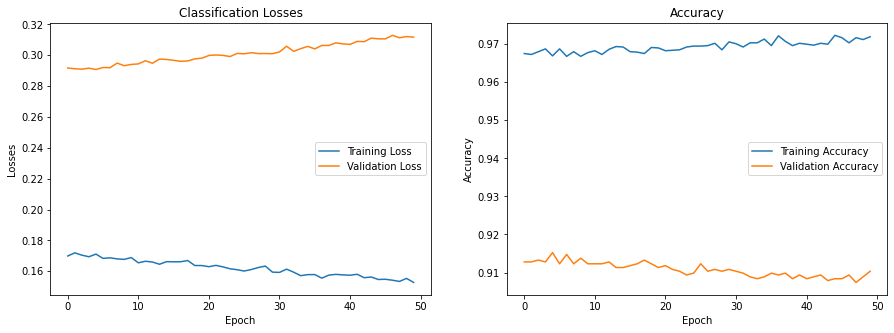

In [56]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Classification Losses")
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

In [57]:
#load best model
from keras.models import load_model
bm = load_model('checkpoint.hdf5')

In [58]:
#model predictions
ypred = bm.predict(dataset_test,batch_size=128)

In [59]:
labelpred = np.where(ypred > 0.5, 1, 0)
#print(labelpred)

In [60]:
from sklearn import metrics

In [61]:
print(metrics.confusion_matrix(label_test, labelpred))

[[973  60]
 [102 906]]


In [62]:
print(metrics.classification_report(label_test, labelpred, digits=3))

              precision    recall  f1-score   support

           0      0.905     0.942     0.923      1033
           1      0.938     0.899     0.918      1008

    accuracy                          0.921      2041
   macro avg      0.922     0.920     0.921      2041
weighted avg      0.921     0.921     0.921      2041



In [63]:
#gradcam tutorial

In [64]:
#get image index
indexes = np.array(range(10202)).reshape(-1,1)
indexes_train, indexes_test = train_test_split(indexes, test_size=0.2, random_state=1)

In [65]:
indexes_train.shape, indexes_test.shape

((8161, 1), (2041, 1))

In [138]:
#get the maximum probability
vals = ypred.tolist()
vals[:20]

[[0.8011884093284607],
 [0.957672119140625],
 [0.06382430344820023],
 [0.04168511927127838],
 [0.9818511009216309],
 [0.987962543964386],
 [0.03322121128439903],
 [0.018236776813864708],
 [0.9965618252754211],
 [0.6331145167350769],
 [0.022903719916939735],
 [0.034742798656225204],
 [0.0224031750112772],
 [0.021895568817853928],
 [0.8654570579528809],
 [0.986281156539917],
 [0.020889433100819588],
 [0.9279899597167969],
 [0.03454233333468437],
 [0.03780011460185051]]

In [137]:
indexes_test[:20]

array([[6764],
       [9870],
       [3846],
       [ 736],
       [7974],
       [5134],
       [ 307],
       [2106],
       [6697],
       [6133],
       [1186],
       [3775],
       [ 695],
       [4880],
       [8728],
       [8205],
       [3261],
       [6751],
       [2305],
       [3399]])

In [381]:
index_img = 5174
cam_img = dataset1d[index_img].reshape(1,4,300)

In [382]:
cam_img.shape

(1, 4, 300)

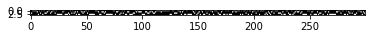

In [383]:
plt.imshow(dataset1d[index_img], cmap='gray')

In [356]:
prediction = bm.predict(cam_img)

In [357]:
prediction

array([[0.03454232]], dtype=float32)

In [358]:
#target class is 1

In [359]:
last_conv = model.get_layer('conv1d_2')


In [360]:
model.output

<tf.Tensor 'dense_3/Sigmoid:0' shape=(None, 1) dtype=float32>

In [361]:
grads = K.gradients(model.output[:,0],last_conv.output)[0]

In [362]:
grads

<tf.Tensor 'gradients_11/max_pooling1d_2/ExpandDims_grad/Reshape:0' shape=(None, 2, 64) dtype=float32>

In [363]:
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([cam_img])

In [364]:
pooled_grads_value,conv_layer_output.shape

(-0.00013494791, (2, 64))

In [365]:
for i in range(64):
    conv_layer_output[:,i] *= pooled_grads_value
#heatmap = np.mean(conv_layer_output,axis=-1)

In [366]:
conv_layer_output.shape

(2, 64)

In [367]:
heatmap = np.mean(conv_layer_output,axis=0)


In [368]:
heatmap = heatmap.reshape(1,64)

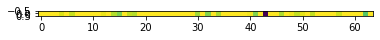

In [369]:
plt.imshow(heatmap)

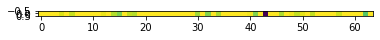

In [370]:
plt.imshow(heatmap)

In [371]:
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

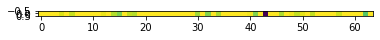

In [372]:
plt.imshow(heatmap)

In [373]:
heatmap

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        -2.2548420e-06,  0.0000000e+00, -3.4969582e-06,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        -1.1675090e-06,  0.0000000e+00, -4.7905287e-06, -8.0278933e-06,
         0.0000000e+00, -3.8697772e-06, -4.6139144e-06,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -5.7821626e-06,  0.0000000e+00,
        -7.6222987e-06,  0.0000000e+00, -5.2806313e-06,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        -7.5145101e-07, -7.7906107e-06,  0.0000000e+00, -4.1278043e-05,
         0.0000000e+00,  0.0000000e+00, -5.1184229e-06,  0.0000000e+00,
        -9.1875313e-07, -3.7724005e-06, -1.5649596e-06,  0.0000000e+00,
        -3.7613975e-06,  0.0000000e+00,  0.0000000e+00,  0.00000

In [374]:
heatmap = np.maximum(heatmap,0)
#heatmap /= np.max(heatmap)

In [375]:
heatmap

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

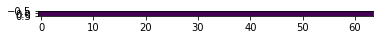

In [376]:
plt.imshow(heatmap)

In [377]:
#import cv2

In [378]:
from skimage.transform import resize

In [379]:
#plt.figure(figsize=(4,300))
upsample = resize(heatmap, (4,300),preserve_range=True)
#plt.imshow(cam_img.squeeze(), cmap='gray')
#plt.imshow(upsample,alpha=1)

#plt.show()

(-0.5, 299.5, 3.5, -0.5)

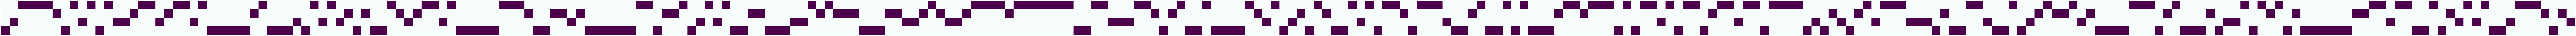

In [384]:
fig, ax = plt.subplots(figsize=(300, 4))
ax.imshow(cam_img.squeeze(), cmap='BuPu',interpolation='nearest')
#ax.imshow(upsample, interpolation='nearest',alpha=0.5,cmap='viridis')
plt.axis('off')